In [144]:
import numpy as np
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from GRU_model import GRUNet
from dataset import SolarDataset
import os

In [145]:
solar_test = np.genfromtxt('data/test_data/test_solar.csv', delimiter=',', skip_header=1)
wind_test = np.genfromtxt('data/test_data/test_wind.csv', delimiter=',', skip_header=1)

solar_no_norm = np.genfromtxt('data/test_data/test_solar_unnorm.csv', delimiter=',', skip_header=1)
wind_no_norm = np.genfromtxt('data/test_data/test_wind_unnorm.csv', delimiter=',', skip_header=1)

In [146]:
test_results = 'test_results/'
if not os.path.exists(test_results):
    os.makedirs(test_results)

In [147]:
solar_test[:5]

array([[-1.        , -1.        , -1.        , -1.        , -0.11063331,
         0.20199429,  0.        ,  1.        ,  5.        ,  1.        ,
         1.        ],
       [-1.        , -1.        , -1.        , -1.        , -0.11329941,
         0.20199429,  1.        ,  1.        ,  5.        ,  1.        ,
         1.        ],
       [-1.        , -1.        , -1.        , -1.        , -0.11809237,
         0.20199429,  2.        ,  1.        ,  5.        ,  1.        ,
         1.        ],
       [-1.        , -1.        , -1.        , -1.        , -0.12380121,
         0.20199429,  3.        ,  1.        ,  5.        ,  1.        ,
         1.        ],
       [-1.        , -1.        , -1.        , -1.        , -0.12981724,
         0.20199429,  4.        ,  1.        ,  5.        ,  1.        ,
         1.        ]])

In [148]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [149]:
def move_sliding_window_24h(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead

    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)
    return inputs, labels

In [150]:
criterion = nn.MSELoss()

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [152]:
WINDOW_SIZE = 25
solar_X_1h, solar_y_1h = move_sliding_window(solar_test, WINDOW_SIZE, range(11), 0)
dataloader = torch.utils.data.DataLoader(SolarDataset(solar_X_1h, solar_y_1h), batch_size=1, shuffle=False)


(8735, 25, 11) (8735, 1)


In [153]:
print(solar_X_1h[0], solar_y_1h[0])

[[-1.         -1.         -1.         -1.         -0.11063331  0.20199429
   0.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.11329941  0.20199429
   1.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.11809237  0.20199429
   2.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.12380121  0.20199429
   3.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.12981724  0.20199429
   4.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.13534257  0.20199429
   5.          1.          5.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.14018368  0.20199429
   6.          1.          5.          1.          1.        ]
 [-0.99999176 -0.99999974 -0.99999939 -1.

In [154]:

INPUT_SIZE = solar_X_1h.shape[2]
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64
NUM_LAYERS = 1

In [155]:
def evaluate(model, dataloader, criterion):
    model.eval()
    outputs = []
    targets = []
    losses = []
    start_time = time.process_time()
    # get data of test data for each state
    
    
        # predict outputs
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)

            h = model.init_hidden(1)
            
            # drop first dimension of h
           
           # print(inputs.shape, h.shape)
            out, h = model(inputs, h)
            
            loss = torch.sqrt(criterion(labels, out) + 1e-8)
            print(f"Loss: {loss.item()}")
            losses.append(loss.item())
            outputs.append(out.cpu().numpy())
            targets.append(labels.cpu().numpy())

    print(f"Evaluation Time: {time.process_time()-start_time}")
    
    
    # list of of targets/outputs for each state
    return outputs, targets, losses

In [156]:
solar_1h_model = GRUNet(INPUT_SIZE, 64, 1,1).to(device)
solar_1h_model.load_state_dict(torch.load('model_1_solar_new.pth', map_location=torch.device('cpu')))
solar_1h_model.eval()


c:\Users\Béla\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


GRUNet(
  (gru): GRU(11, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [157]:
outputs_solar_1, targets_solar_1, rmse_solar_1 = evaluate(solar_1h_model,dataloader, criterion)

Loss: 0.04123753681778908
Loss: 0.021040737628936768
Loss: 0.019323846325278282
Loss: 0.024464931339025497
Loss: 0.02772623486816883
Loss: 0.028385339304804802
Loss: 0.025715606287121773
Loss: 0.023121751844882965
Loss: 0.030847890302538872
Loss: 0.043078240007162094
Loss: 0.05387208238244057
Loss: 0.05970432981848717
Loss: 0.058696772903203964
Loss: 0.060018979012966156
Loss: 0.053623829036951065
Loss: 0.052755989134311676
Loss: 0.054039452224969864
Loss: 0.0542854405939579
Loss: 0.05494919419288635
Loss: 0.0552355982363224
Loss: 0.05560687556862831
Loss: 0.05585196614265442
Loss: 0.05611255764961243
Loss: 0.056354910135269165
Loss: 0.02568836510181427
Loss: 0.009414905682206154
Loss: 0.007694298401474953
Loss: 0.008244107477366924
Loss: 0.007555908057838678
Loss: 0.005373812280595303
Loss: 0.0008977492107078433
Loss: 0.0038598619867116213
Loss: 0.002087724395096302
Loss: 0.01636875420808792
Loss: 0.030953092500567436
Loss: 0.04154837131500244
Loss: 0.04518156126141548
Loss: 0.0470875

In [158]:
# get average loss
print(f"Average RMSE: {np.mean(rmse_solar_1)}")

Average RMSE: 0.0745751690590189


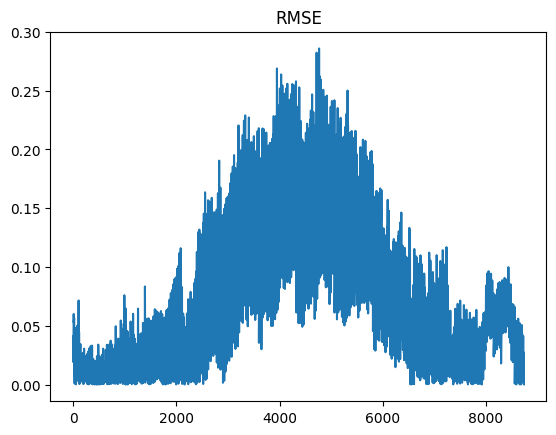

In [159]:
# plot loss
plt.plot(rmse_solar_1)
plt.title("RMSE")
plt.show()


In [160]:
# shape outputs and targets to be able to plot
outputs_solar = np.array(outputs_solar_1).reshape(-1,1)
targets_solar = np.array(targets_solar_1).reshape(-1,1)
#save outputs and targets
np.savetxt(test_results +'/outputs_solar_1h.csv', outputs_solar, delimiter=',')
np.savetxt(test_results + '/targets_solar_1h.csv', targets_solar, delimiter=',')

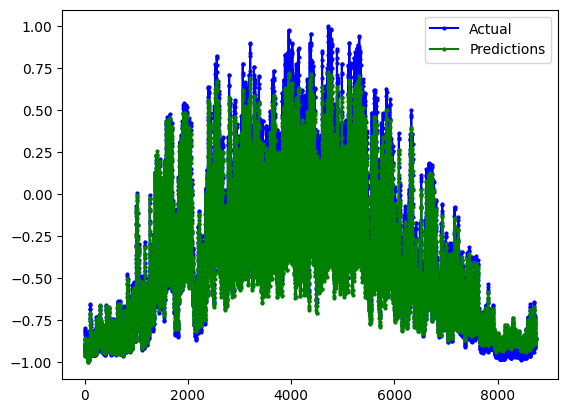

In [161]:
#plot the results
plt.plot(targets_solar, "-o", color="b", label="Actual", markersize=2)
plt.plot(outputs_solar, "-o", color="g", label="Predictions", markersize=2)
plt.legend()
plt.show()


In [162]:
print(len(outputs_solar))

8735


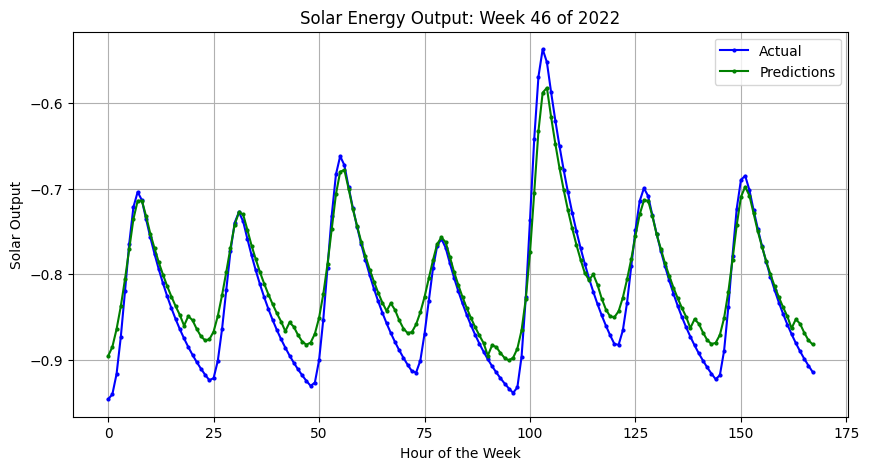

In [163]:
# Number of hours per week
hours_per_week = 7 * 24

# Maximum index for the start of a week in the dataset
max_week_index = len(targets_solar) - hours_per_week

# Select a random start hour from 0 to the maximum possible index that still allows for a full week of data
start_hour = np.random.randint(0, max_week_index + 1)

# Calculate the corresponding week number (for title purposes)
week_number = start_hour // hours_per_week + 1

# Plot actual vs. predicted solar energy outputs for the selected week
plt.figure(figsize=(10, 5))
plt.plot(targets_solar[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
plt.plot(outputs_solar[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions", markersize=2)
plt.legend()
plt.title(f"Solar Energy Output: Week {week_number} of 2022")
plt.xlabel("Hour of the Week")
plt.ylabel("Solar Output")
plt.grid(True)
plt.show()

In [164]:
HIDDEN_SIZE = 16
NUM_LAYERS = 1

wind_X_1h, wind_y_1h = move_sliding_window(wind_test, WINDOW_SIZE, range(11), 0)
dataloader = torch.utils.data.DataLoader(SolarDataset(wind_X_1h, wind_y_1h), batch_size=1, shuffle=False)

(8735, 25, 11) (8735, 1)


In [165]:
wind_model_1h = GRUNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
wind_model_1h.load_state_dict(torch.load('models/total_wind_1h_model.pth'))
wind_model_1h.eval()

GRUNet(
  (gru): GRU(11, 16, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [166]:
outputs_wind_1, targets_wind_1, rmse = evaluate(wind_model_1h,dataloader, criterion)


Loss: 0.017930062487721443
Loss: 0.032629143446683884
Loss: 0.03190597519278526
Loss: 0.039948973804712296
Loss: 0.03557351231575012
Loss: 0.035820383578538895
Loss: 0.03156087175011635
Loss: 0.027796829119324684
Loss: 0.03443023934960365
Loss: 0.02832913212478161
Loss: 0.029125653207302094
Loss: 0.026200424879789352
Loss: 0.03135029599070549
Loss: 0.02896437980234623
Loss: 0.028179554268717766
Loss: 0.02580590546131134
Loss: 0.024317648261785507
Loss: 0.0238440353423357
Loss: 0.027808338403701782
Loss: 0.02571912296116352
Loss: 0.031249623745679855
Loss: 0.033515363931655884
Loss: 0.03134987875819206
Loss: 0.034023553133010864
Loss: 0.04483448714017868
Loss: 0.04525809735059738
Loss: 0.040992621332407
Loss: 0.027854355052113533
Loss: 0.011504787020385265
Loss: 0.001788433874025941
Loss: 0.004332445096224546
Loss: 0.008955619297921658
Loss: 0.010054906830191612
Loss: 0.010242771357297897
Loss: 0.007346177939325571
Loss: 0.010094840079545975
Loss: 0.011298563331365585
Loss: 0.0142451450

In [167]:
print(f"Average RMSE: {np.mean(rmse)}")

Average RMSE: 0.01885408041621577


In [168]:
outputs_wind_1h = np.array(outputs_wind_1).reshape(-1,1)
targets_wind_1h = np.array(targets_wind_1).reshape(-1,1)
#save the results
np.savetxt(test_results + "/wind_outputs_1h.csv", outputs_wind_1h, delimiter=",")
np.savetxt(test_results + "/wind_targets_1h.csv", targets_wind_1h, delimiter=",")

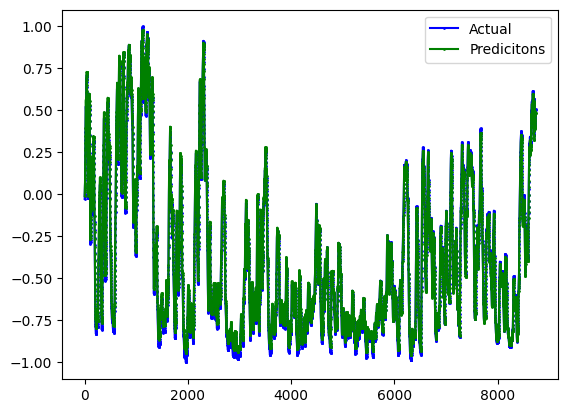

In [169]:
plt.plot(targets_wind_1h, "-o", color="b", label="Actual", markersize=1)
plt.plot(outputs_wind_1h, "-o", color="g", label="Predicitons", markersize=1)
plt.legend()
plt.show()

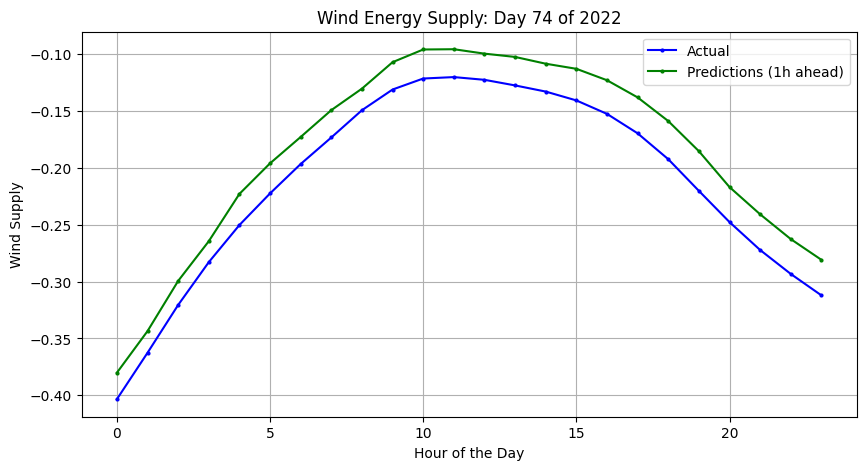

In [170]:
hours_per_day = 24

# Maximum index for the start of a day in the dataset
max_day_index = len(targets_wind_1h) - hours_per_day

# Select a random start hour from 0 to the maximum possible index that still allows for a full day of data
start_hour = np.random.randint(0, max_day_index + 1)

# Calculate the corresponding day number (for title purposes)
day_number = start_hour // hours_per_day + 1

# Plot actual vs. predicted wind energy outputs for the selected day
plt.figure(figsize=(10, 5))
plt.plot(targets_wind_1h[start_hour:start_hour + hours_per_day], "-o", color="b", label="Actual", markersize=2)
plt.plot(outputs_wind_1h[start_hour:start_hour + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
plt.legend()
plt.title(f"Wind Energy Supply: Day {day_number} of 2022")
plt.xlabel("Hour of the Day")
plt.ylabel("Wind Supply")
plt.grid(True)
plt.show()

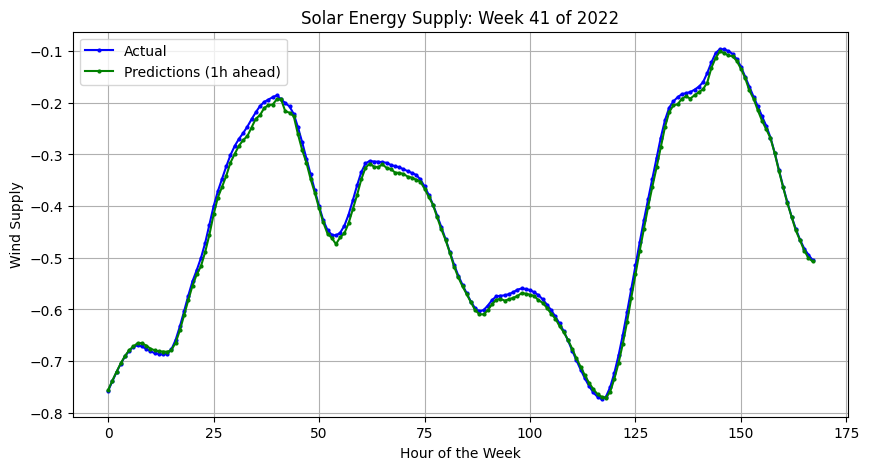

In [171]:
# Number of hours per week
hours_per_week = 7 * 24

# Maximum index for the start of a week in the dataset
max_week_index = len(targets_wind_1h) - hours_per_week

# Select a random start hour from 0 to the maximum possible index that still allows for a full week of data
start_hour = np.random.randint(0, max_week_index + 1)

# Calculate the corresponding week number (for title purposes)
week_number = start_hour // hours_per_week + 1

# Plot actual vs. predicted solar energy outputs for the selected week
plt.figure(figsize=(10, 5))
plt.plot(targets_wind_1h[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
plt.plot(outputs_wind_1h[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
plt.legend()
plt.title(f"Solar Energy Supply: Week {week_number} of 2022")
plt.xlabel("Hour of the Week")
plt.ylabel("Wind Supply")
plt.grid(True)
plt.show()

In [172]:
solar_X_24h, solar_y_24h = move_sliding_window_24h(solar_test, 72, range(11), 0, 24)#
dataloader = torch.utils.data.DataLoader(SolarDataset(solar_X_24h, solar_y_24h), batch_size=1, shuffle=False)


(8665, 72, 11) (8665, 1)


In [173]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
HIDDEN_SIZE = 64
NUM_LAYERS = 2
solar_24h_model = GRUNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE,NUM_LAYERS).to(device)
solar_24h_model.load_state_dict(torch.load('model_24_solar_new.pth', map_location=device))
solar_24h_model.eval()


GRUNet(
  (gru): GRU(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [175]:
outputs_solar_24, targets_solar_24, rmse = evaluate(solar_24h_model,dataloader, criterion)



Loss: 0.02777785249054432
Loss: 0.026828236877918243
Loss: 0.018245672807097435
Loss: 0.008947275578975677
Loss: 0.001987054478377104
Loss: 0.0022614665795117617
Loss: 0.0023254805710166693
Loss: 0.004618237726390362
Loss: 0.022565467283129692
Loss: 0.051784612238407135
Loss: 0.07817012071609497
Loss: 0.08390408754348755
Loss: 0.06314857304096222
Loss: 0.023404335603117943
Loss: 0.01759122498333454
Loss: 0.04513555020093918
Loss: 0.05457279458642006
Loss: 0.05478552356362343
Loss: 0.054580897092819214
Loss: 0.054521117359399796
Loss: 0.054089877754449844
Loss: 0.05269400030374527
Loss: 0.04986630007624626
Loss: 0.0453292652964592
Loss: 0.03901822492480278
Loss: 0.027096755802631378
Loss: 0.02696937881410122
Loss: 0.0308676790446043
Loss: 0.03375145420432091
Loss: 0.0352267250418663
Loss: 0.03505953401327133
Loss: 0.031227152794599533
Loss: 0.02040845900774002
Loss: 0.00011656899005174637
Loss: 0.012365387752652168
Loss: 0.00046425085747614503
Loss: 0.04448186606168747
Loss: 0.110378548

In [176]:
average_rmse = np.mean(rmse)
print(f"Average RMSE: {average_rmse}")
#Average RMSE: 0.23142031165367208

Average RMSE: 0.2314203190283921


In [177]:
outputs_solar_24 = np.array(outputs_solar_24).reshape(-1,1)
targets_solar_24 = np.array(targets_solar_24).reshape(-1,1)
#save the results
np.savetxt(test_results + "/solar_outputs_24h.csv", outputs_solar_24, delimiter=",")
np.savetxt(test_results + "/solar_targets_24h.csv", targets_solar_24, delimiter=",")

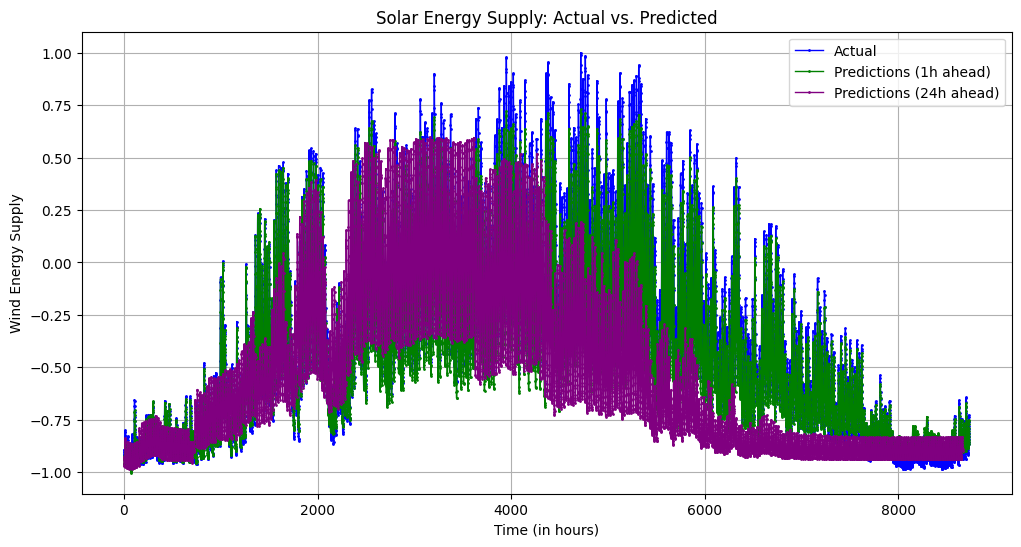

In [178]:

plt.figure(figsize=(12, 6))  # Set a larger figure size for better visibility

# Plotting the actual wind data
plt.plot(targets_solar, "-o", color="blue", label="Actual", markersize=1, linewidth=1)

# Plotting the predictions for 1 hour ahead
plt.plot(outputs_solar, "-o", color="green", label="Predictions (1h ahead)", markersize=1, linewidth=1)

# Plotting the predictions for 24 hours ahead
plt.plot(outputs_solar_24, "-o", color="purple", label="Predictions (24h ahead)", markersize=1, linewidth=1)

# Adding a legend to the plot
plt.legend()

# Adding a grid for better readability of the plot
plt.grid(True)

# Setting the title of the plot
plt.title("Solar Energy Supply: Actual vs. Predicted")

# Labeling the x-axis
plt.xlabel("Time (in hours)")

# Labeling the y-axis
plt.ylabel("Wind Energy Supply")

# Displaying the plot
plt.savefig("plots/testing/solar_predictions_total.png")
plt.show()

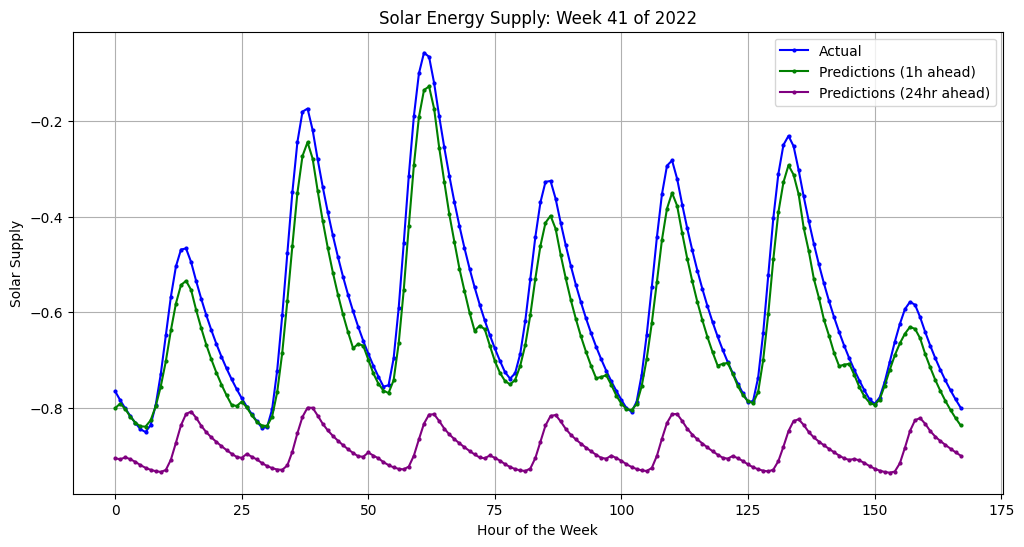

In [179]:
# Number of hours per week
hours_per_week = 7 * 24

# Adjust start hour for plotting from hour 24 to align all datasets
# Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
max_week_index = len(outputs_solar_24) - hours_per_week  # Use outputs_solar_24 length to define the week's limits

# Select a random start hour from 24 to the maximum possible index that still allows for a full week of data
start_hour = np.random.randint(24, max_week_index + 1)

# Calculate the corresponding week number (for title purposes)
week_number = (start_hour - 24) // hours_per_week + 1

# Plot actual vs. predicted solar energy outputs for the selected week, starting from the 24th hour
plt.figure(figsize=(12, 6))
plt.plot(range(hours_per_week), targets_solar[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
plt.plot(range(hours_per_week), outputs_solar[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
plt.plot(range(hours_per_week), outputs_solar_24[start_hour - 24:start_hour - 24 + hours_per_week], "-o", color="purple", label="Predictions (24hr ahead)", markersize=2)

plt.legend()
plt.title(f"Solar Energy Supply: Week {week_number} of 2022")
plt.xlabel("Hour of the Week")
plt.ylabel("Solar Supply")
plt.grid(True)
plt.savefig(f"plots/testing/solar_energy_supply_week_{week_number}_window.png")
plt.show()

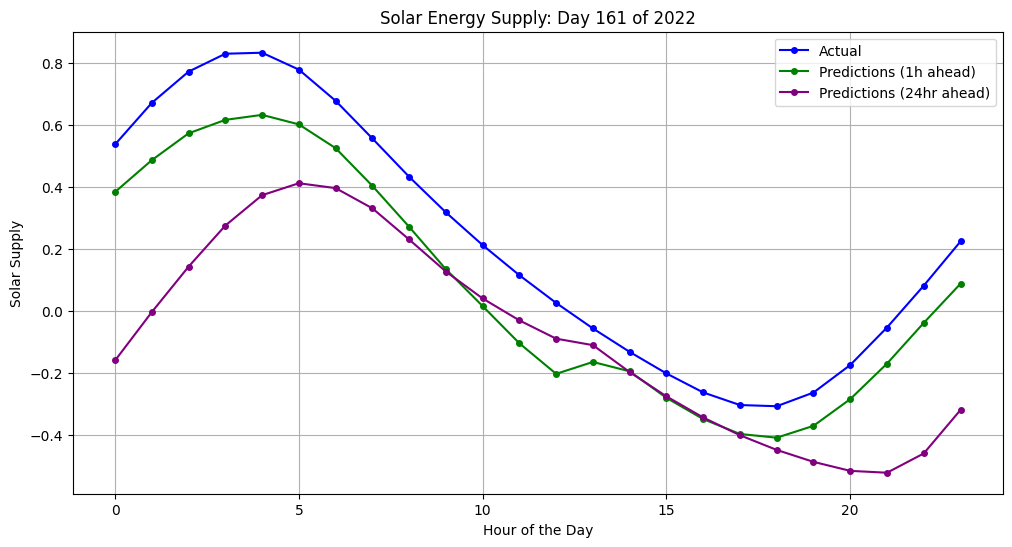

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming example data setup; ensure these arrays are correctly referenced and sized
# targets_solar = np.random.rand(8735)  # Actual solar outputs
# outputs_solar = np.random.rand(8735)  # Predictions synced with actual data
# outputs_solar_24 = np.random.rand(8712)  # Predictions for 24 hours ahead

# Number of hours per day
hours_per_day = 24

# Adjust start hour for plotting from hour 24 to align all datasets
# Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
max_day_index = len(outputs_solar_24) - hours_per_day  # Use outputs_solar_24 length to define the day's limits

# Select a random start hour from 24 to the maximum possible index that still allows for a full day of data
start_hour = np.random.randint(24, max_day_index + 1)

# Calculate the corresponding day number (for title purposes)
day_number = (start_hour - 24) // hours_per_day + 1

# Plot actual vs. predicted solar energy outputs for the selected day, starting from the 24th hour
plt.figure(figsize=(12, 6))
plt.plot(range(hours_per_day), targets_solar[start_hour:start_hour + hours_per_day], "-o", color="b", label="Actual", markersize=4)
plt.plot(range(hours_per_day), outputs_solar[start_hour:start_hour + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
plt.plot(range(hours_per_day), outputs_solar_24[start_hour - 24:start_hour - 24 + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)

plt.legend()
plt.title(f"Solar Energy Supply: Day {day_number} of 2022")
plt.xlabel("Hour of the Day")
plt.ylabel("Solar Supply")
plt.grid(True)
plt.savefig(f"plots/testing/solar_energy_supply_day_{day_number}_window.png")
plt.show()


In [181]:
wind_X_24h, wind_y_24h = move_sliding_window_24h(wind_test, 72, range(11), 0, 24)
dataloaders = torch.utils.data.DataLoader(SolarDataset(wind_X_24h, wind_y_24h), batch_size=1, shuffle=False)


(8665, 72, 11) (8665, 1)


In [182]:
HIDDEN_SIZE = 16
NUM_LAYERS = 1
wind_model_24h = GRUNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE,NUM_LAYERS).to(device)
wind_model_24h.load_state_dict(torch.load('models/seq_len_72/total_wind_24h_model.pth', map_location=device))

<All keys matched successfully>

In [183]:
outputs_wind_24, targets_wind_24, rmse = evaluate(wind_model_24h,dataloaders, criterion)


Loss: 0.40442848205566406
Loss: 0.3911550045013428
Loss: 0.35446697473526
Loss: 0.30243271589279175
Loss: 0.24065564572811127
Loss: 0.1752304583787918
Loss: 0.10761086642742157
Loss: 0.037756338715553284
Loss: 0.03194441646337509
Loss: 0.10189525038003922
Loss: 0.17187289893627167
Loss: 0.24122795462608337
Loss: 0.3089978098869324
Loss: 0.3731454908847809
Loss: 0.4328136444091797
Loss: 0.48417025804519653
Loss: 0.5256240963935852
Loss: 0.5561978816986084
Loss: 0.576731264591217
Loss: 0.5945625901222229
Loss: 0.6089103817939758
Loss: 0.6158246994018555
Loss: 0.6152637004852295
Loss: 0.6086481213569641
Loss: 0.5977988839149475
Loss: 0.5649281144142151
Loss: 0.5421836376190186
Loss: 0.5186165571212769
Loss: 0.48569369316101074
Loss: 0.4436572790145874
Loss: 0.39177680015563965
Loss: 0.3250466585159302
Loss: 0.24565526843070984
Loss: 0.15896429121494293
Loss: 0.06697329878807068
Loss: 0.025510253384709358
Loss: 0.11782195419073105
Loss: 0.20710721611976624
Loss: 0.2900656759738922
Loss: 0.

In [184]:
outputs_wind_24 = np.array(outputs_wind_24).reshape(-1,1)
targets_wind_24 = np.array(targets_wind_24).reshape(-1,1)
#save the results
np.savetxt(test_results + "/outputs_wind_24h.csv", outputs_wind_24, delimiter=",")
np.savetxt(test_results + "/targets_wind_24h.csv", targets_wind_24, delimiter=",")
print(f"Average RMSE: {np.mean(rmse)}")
#Average RMSE: 0.2523170205728958


Average RMSE: 0.2414837433453838


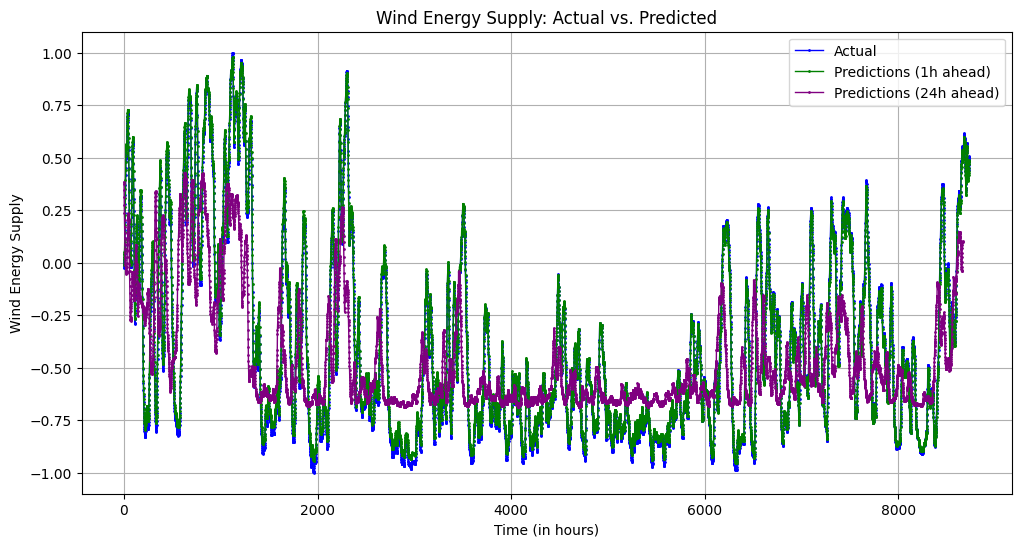

In [185]:

plt.figure(figsize=(12, 6))  # Set a larger figure size for better visibility

# Plotting the actual wind data
plt.plot(targets_wind_1h, "-o", color="blue", label="Actual", markersize=1, linewidth=1)

# Plotting the predictions for 1 hour ahead
plt.plot(outputs_wind_1h, "-o", color="green", label="Predictions (1h ahead)", markersize=1, linewidth=1)

# Plotting the predictions for 24 hours ahead
plt.plot(outputs_wind_24, "-o", color="purple", label="Predictions (24h ahead)", markersize=1, linewidth=1)

# Adding a legend to the plot
plt.legend()

# Adding a grid for better readability of the plot
plt.grid(True)

# Setting the title of the plot
plt.title("Wind Energy Supply: Actual vs. Predicted")

# Labeling the x-axis
plt.xlabel("Time (in hours)")

# Labeling the y-axis
plt.ylabel("Wind Energy Supply")
plt.savefig("plots/testing/wind_predictions_total.png")
# Displaying the plot
plt.show()

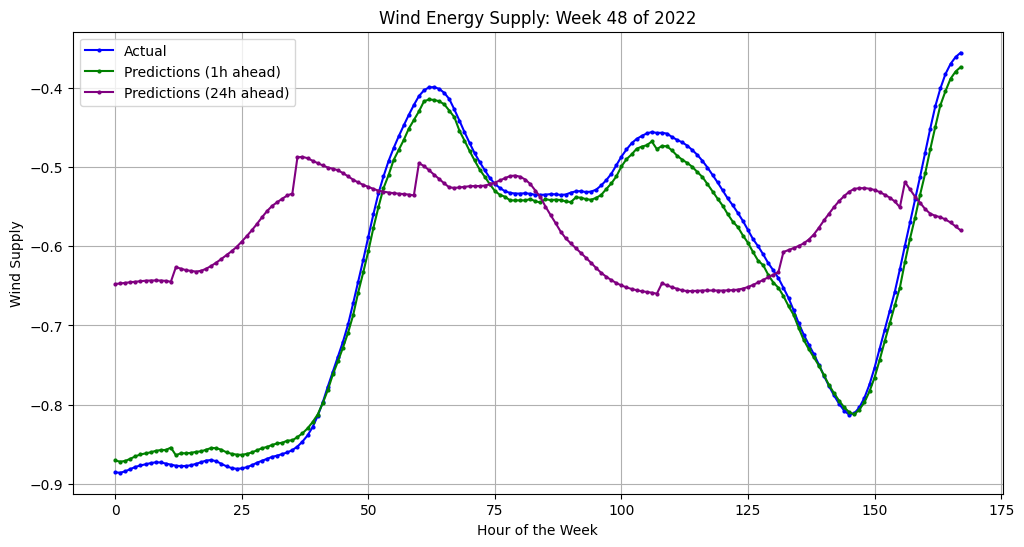

In [186]:
# Number of hours per week
hours_per_week = 7 * 24

# Adjust start hour for plotting from hour 24 to align all datasets
# Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
max_week_index = len(outputs_wind_24) - hours_per_week  # Use outputs_solar_24 length to define the week's limits

# Select a random start hour from 24 to the maximum possible index that still allows for a full week of data
start_hour = np.random.randint(24, max_week_index + 1)

# Calculate the corresponding week number (for title purposes)
week_number = (start_hour - 24) // hours_per_week + 1

# Plot actual vs. predicted solar energy outputs for the selected week, starting from the 24th hour
plt.figure(figsize=(12, 6))
plt.plot(range(hours_per_week), targets_wind_1h[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
plt.plot(range(hours_per_week), outputs_wind_1h[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
plt.plot(range(hours_per_week), outputs_wind_24[start_hour - 24:start_hour - 24 + hours_per_week], "-o", color="purple", label="Predictions (24h ahead)", markersize=2)

plt.legend()
plt.title(f"Wind Energy Supply: Week {week_number} of 2022")
plt.xlabel("Hour of the Week")
plt.ylabel("Wind Supply")
plt.grid(True)
plt.savefig(f"plots/testing/wind_energy_supply_week_{week_number}_window.png")
plt.show()

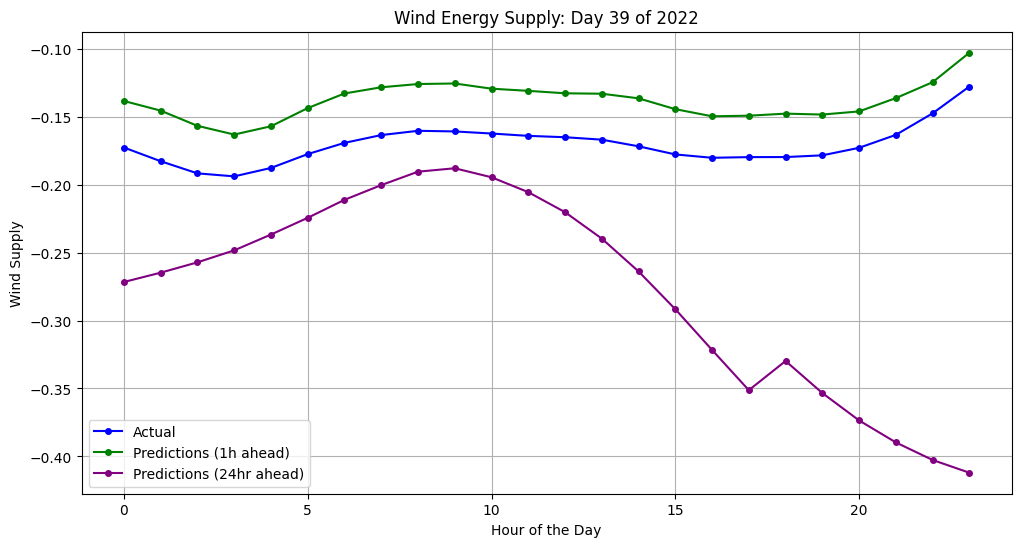

In [187]:
hours_per_day = 24

# Adjust start hour for plotting from hour 24 to align all datasets
# Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
max_day_index = len(outputs_wind_24) - hours_per_day  # Use outputs_solar_24 length to define the day's limits

# Select a random start hour from 24 to the maximum possible index that still allows for a full day of data
start_hour = np.random.randint(24, max_day_index + 1)

# Calculate the corresponding day number (for title purposes)
day_number = (start_hour - 24) // hours_per_day + 1

# Plot actual vs. predicted solar energy outputs for the selected day, starting from the 24th hour
plt.figure(figsize=(12, 6))
plt.plot(range(hours_per_day), targets_wind_1h[start_hour:start_hour + hours_per_day], "-o", color="b", label="Actual", markersize=4)
plt.plot(range(hours_per_day), outputs_wind_1h[start_hour:start_hour + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
plt.plot(range(hours_per_day), outputs_wind_24[start_hour - 24:start_hour - 24 + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)

plt.legend()
plt.title(f"Wind Energy Supply: Day {day_number} of 2022")
plt.xlabel("Hour of the Day")
plt.ylabel("Wind Supply")
plt.grid(True)
plt.savefig(f"plots/testing/wind_energy_supply_day_{day_number}_window.png")
plt.show()